### Load tensorflow and start Eager mode

In [3]:
import tensorflow as tf

In [4]:
tf.enable_eager_execution()

In [5]:
hello = tf.constant('Hello World')
print(hello)

tf.Tensor(b'Hello World', shape=(), dtype=string)


In [6]:
hello = tf.constant('Hello World', shape=(6,2))
print(hello)

tf.Tensor(
[[b'Hello World' b'Hello World']
 [b'Hello World' b'Hello World']
 [b'Hello World' b'Hello World']
 [b'Hello World' b'Hello World']
 [b'Hello World' b'Hello World']
 [b'Hello World' b'Hello World']], shape=(6, 2), dtype=string)


In [7]:
hello.numpy()

array([[b'Hello World', b'Hello World'],
       [b'Hello World', b'Hello World'],
       [b'Hello World', b'Hello World'],
       [b'Hello World', b'Hello World'],
       [b'Hello World', b'Hello World'],
       [b'Hello World', b'Hello World']], dtype=object)

### Download Content and Style images

In [ ]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget -q https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg

Visualize the images

In [8]:
content_img =  tf.keras.preprocessing.image.load_img('Green_Sea_Turtle_grazing_seagrass.jpg')
style_img = tf.keras.preprocessing.image.load_img('The_Great_Wave_off_Kanagawa.jpg')

In [9]:
import matplotlib.pyplot as plt

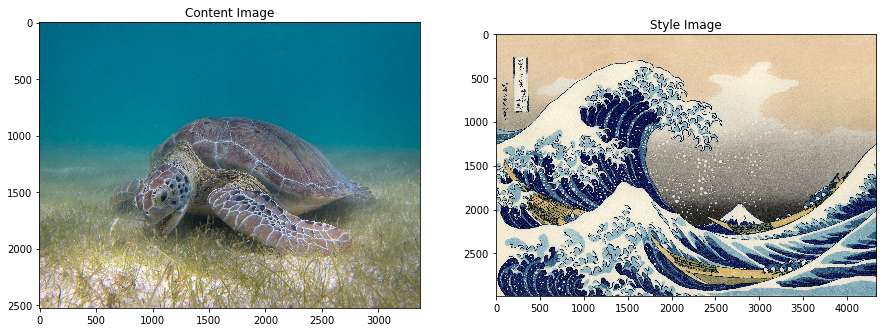

In [10]:
plt.figure(figsize=(15,15))

#Display content image
plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')

#Display content image
plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')

plt.show()

In [11]:
content_img.size

(3367, 2525)

Resize image

In [12]:
def resize_image(img_file):
    
    #Max image dimension
    max_img_side = 400
    
    #Load image
    img = tf.keras.preprocessing.image.load_img(img_file)
    
    #Get size
    w, h = img.size
    bigger_side_size = max(img.size)
    
    #Scale to use
    scale = max_img_side/bigger_side_size
    
    #Resize image
    img = img.resize((round(w*scale),round(h*scale)))    
    
    return img

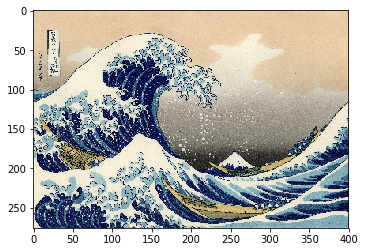

In [13]:
plt.imshow(resize_image('The_Great_Wave_off_Kanagawa.jpg'))

### Build model

Load pre-trained model

In [14]:
#Load pre-trained network
vgg_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

In [15]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Define layers that we are interested in

In [16]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

Get Style and Content layers Output

In [17]:
#Get output for style layer(s)
style_op = [vgg_model.get_layer(layer).output for layer in style_layers]

#Get output for content layer(s)
content_op = [vgg_model.get_layer(layer).output for layer in content_layers]

#Combined output
combined_op = style_op + content_op

Define the actual model to use

In [18]:
#Model outputs
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=combined_op)

Set all Layers as non-trainable

In [19]:
for layer in model.layers:
    
    layer.trainable = False

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Extract Style and Content features

In [21]:
import numpy as np

In [22]:
def preprocess_image(img_file):
    
    #Load and resize image
    img = resize_image(img_file)
    
    #Convert it into array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    #Preprocess numpy array for VGG19
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)
    
    #Make it a batch of 1
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [23]:
def get_features(img_file):
    
    #Preprocess numpy array for VGG19
    img_array = preprocess_image(img_file)
    
    #Get outputs
    img_op = model(img_array)
    
    #Get Style and content features
    style_features = [op[0] for op in img_op[:len(style_layers)]]
    content_features = [op[0] for op in img_op[len(style_layers):]]
    
    return style_features, content_features

### Calculate Loss

Content Loss

In [24]:
def content_loss(actual, prediction):
    
    c_loss = tf.reduce_mean(tf.square(actual - prediction))
    
    return c_loss

Style Loss

In [25]:
#Calculate Gram Matrix
def gram_matrix(layer_op):
    
    depth = int(layer_op.shape[-1])
    a = tf.reshape(layer_op, [-1, depth])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    
    return gram/tf.cast(n, tf.float32)

In [26]:
def style_loss(actual, prediction):
    
    gram_actual = gram_matrix(actual)
    gram_prediction = gram_matrix(prediction)
    
    return tf.reduce_mean(tf.square(gram_actual - gram_prediction))

Define Total LOSS

In [27]:
def total_loss(new_img, actual_style_features, actual_content_features, loss_weights):
    
    #Get model output for new_img
    model_op = model(new_img)
    
    #Get features
    new_style_features = model_op[:len(style_layers)]
    new_content_features = model_op[len(style_layers):]
    
    #Initialize loss
    cur_style_loss = 0
    cur_content_loss = 0
    
    #Calculate Style loss for all layers
    for i in range(len(style_layers)):
        
        cur_style_loss += style_loss(actual_style_features[i], new_style_features[i])
        
    #Calculate Content loss
    for i in range(len(content_layers)):
        
        cur_content_loss += content_loss(actual_content_features[i], new_content_features[i])
        
    
    #Normalize loss for number of layers
    cur_style_loss = cur_style_loss / len(style_layers)
    cur_content_loss = cur_content_loss / len(content_layers)
    
    #Combine losses with weightage
    combined_loss = cur_style_loss*loss_weights[0] + cur_content_loss*loss_weights[1]
    
    return combined_loss, cur_style_loss, cur_content_loss

### Calculate Gradients

In [28]:
def calc_gradients(config_info):
    
    #Let tape record all operations to calculate loss
    with tf.GradientTape() as tape:
        loss = total_loss(**config_info)
    
    #Get the combined loss
    combined_loss = loss[0]
    
    #Calculate gradients
    grads = tape.gradient(combined_loss, config_info['new_img'])
    
    return grads, loss

### Style Transfer
Combine it all

In [29]:
import tensorflow.contrib.eager as tfe
import IPython.display

In [33]:
def style_transfer(content_file, style_file):
    
    #Get Style and Content features for Original image
    actual_style_features, _ = get_features(style_file)
    _, actual_content_features = get_features(content_file)
    
    
    #Create new image fpr transformation, we will initialize it with content img
    new_img = preprocess_image(content_file)
    
    #Create a tf variable based on the image
    new_img = tfe.Variable(new_img, dtype=tf.float32)
    
    #Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    #Config info
    config_info = {'new_img': new_img, 
                   'actual_style_features': actual_style_features, 
                   'actual_content_features': actual_content_features, 
                   'loss_weights':[1e-2, 1e3]} #Style weight, Content Weight
    
    #Track lowest loss and best new img
    lowest_loss = float('inf')
    best_img = None
    
    #Keep interim images
    generated_imgs = []
    
    #Clip Values
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    #Run training i.e updating the new img for some iterations
    for i in range(1000):
        
        #Get gradients and all losses
        grads, losses = calc_gradients(config_info)
        
        #Get 3 losses
        combined_loss, style_loss, content_loss = losses
        
        #Apply Gradients
        optimizer.apply_gradients([(grads, new_img)])
        
        #Clip new_img
        clipped_img = tf.clip_by_value(new_img, min_vals, max_vals)        
        new_img.assign(clipped_img)
        
        if combined_loss < lowest_loss:
            
            lowest_loss = combined_loss
            best_img = deprocess_img(new_img.numpy())
            
        
        #Display new_img at regular interval
        if i % 100 == 0:
            
            plot_img = deprocess_img(new_img.numpy())
            generated_imgs.append(plot_img)
            
            IPython.display.clear_output(wait=True)
            
            plot_img =  tf.keras.preprocessing.image.array_to_img(plot_img)
            IPython.display.display_png(plot_img)
            
            print('Iteration:', i, 'Total loss', combined_loss.numpy(), '\n'
                  'Style loss:', style_loss.numpy(), '\n'
                  'Content loss:', content_loss.numpy())
            
    return lowest_loss, best_img, generated_imgs

Deprocess image

In [31]:
def deprocess_img(processed_img):
    
    #Create a copy of processed image
    dp_img = processed_img.copy()
    
    #Remove batch dimension i.e make it 3D from 4D
    dp_img = np.squeeze(dp_img, 0)
    
    #Add the means of VGG19
    dp_img[:,:,0] += 103.939
    dp_img[:,:,1] += 116.779
    dp_img[:,:,2] += 123.68
    
    #BGR to RGB
    dp_img = dp_img[:,:,::-1]
    
    dp_img = np.clip(dp_img, 0, 255)
    
    return dp_img

Run it ALL

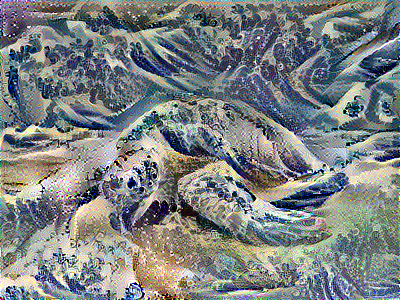

Iteration: 900 Total loss 1864470.2 
Style loss: 100076930.0 
Content loss: 863.7009


In [54]:
loss, best_img, generated_imgs = style_transfer('Green_Sea_Turtle_grazing_seagrass.jpg', #Content
                                                'The_Great_Wave_off_Kanagawa.jpg') #Style

Check all 3 images together

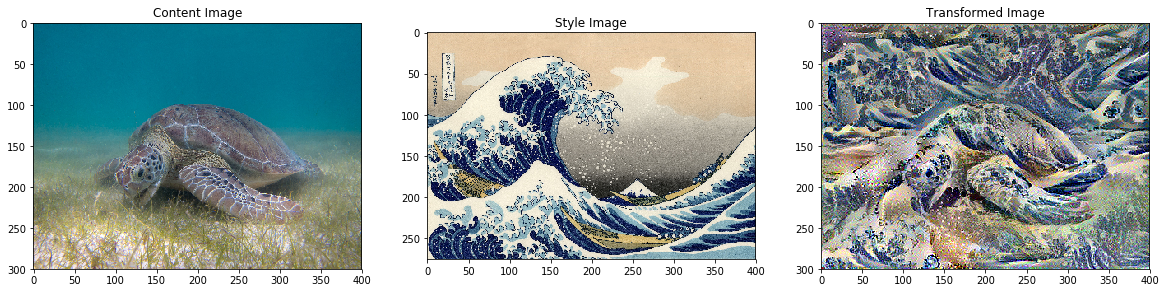

In [38]:
plt.figure(figsize=(20,15))

#Display content image
plt.subplot(1,3,1)
plt.imshow(resize_image('Green_Sea_Turtle_grazing_seagrass.jpg'))
plt.title('Content Image')

#Display Style image
plt.subplot(1,3,2)
plt.imshow(resize_image('The_Great_Wave_off_Kanagawa.jpg'))
plt.title('Style Image')

#Display Style image
plt.subplot(1,3,3)
plt.imshow(tf.keras.preprocessing.image.array_to_img(best_img))
plt.title('Transformed Image')

plt.show()

### Applying it on another set of images

In [52]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/c/cd/VanGogh-starry_night.jpg

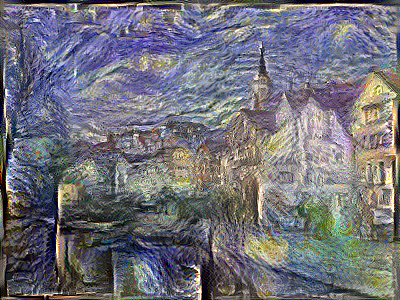

Iteration: 900 Total loss 1105543.1 
Style loss: 42646330.0 
Content loss: 679.07983


In [53]:
loss, best_img, generated_imgs = style_transfer('Tuebingen_Neckarfront.jpg', #Content
                                                'VanGogh-starry_night.jpg') #Style